# 说明：

这个案例与上一个案例不！一！样！

区别的概述：
- 这里：前后几个样本中的数据“特征”相互之间（前面样本的特征x对后面样本的结果y有影响）有影响；
- 前面：每个样本中，文本数据中“一句话内前面内容”会影响对该样本标签的判断；样本与样本之间是没有影响的。

总之：序列预测是样本之间相互影响，文本判断是样本内数据相互影响。—— 都是相互之间有影响，前者范围广，后者范围狭。

感想：序列预测更像是“**高级回归**”！因为它除具备回归问题的各种条件之外，还考虑数据前后的“**彼此影响**”！

# 一、数据预处理

In [1]:
import keras 
from keras import layers
import pandas as pd
import numpy as np

Using TensorFlow backend.


### 读入与查看： 

In [2]:
data = pd.read_csv('E:/Python_code/keras_total/日月光华-keras课程资料/PRSA_data_2010.1.1-2014.12.31.csv')

In [3]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


说明：待预测的是pm2.5列，它后面的列都是不同的属性x；前面是相应的记录的时间（只用来反映先后顺序即可，当作索引即可）

但是待预测的pm2.5列里，有很多的NAN未记录值，并且分布无规律。应对它有两种策略：
- 直接删去：可以，但是可能导致删除后，上下俩数据在时间上不连续且跨度很大！那么前后影响的程度就会减弱甚至是没有了。
- 填充：前面没数据的可以直接删掉，若是夹在中间的NAN可以用填充方式。—— 用前向填充（如使用前天的数据，填充昨天缺失的数据）

因此，总的策略：最前面的24个直接删掉（其前面没有数据没影响），夹在中间的NAN用填充。

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [5]:
data.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

In [6]:
data['pm2.5'].isna().sum()  # 统计看一下有多少个NAN值

2067

### 处理NAN值：

In [7]:
# 先把开头的钱24个NAN数据删掉：
data = data[24:]

In [8]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [9]:
# 把剩下的、夹在中间的NAN用“前向填充方式”：即使NAN连在一起，用前向填充也能都填上！ —— 很好想。
data = data.fillna( method='ffill' )

In [10]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### 把时间处理成样本索引： 

In [11]:
import datetime

In [12]:
# 把表格中表示时间的多列，合并为1列/索引
# 格式：datetime.datetime( year = 2019, month = 11, day = 18, hour = 1)
# 补充：data.apply(lambda函数) —— 在data数据上应用一个lambda函数

# 时间转换后，新添加一列：
data['tm'] = data.apply( lambda x: datetime.datetime(year = x['year'], month = x['month'], day = x['day'], hour = x['hour']), axis = 1 )

In [13]:
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,tm
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


In [14]:
# 没用的时间列都可以删了：换一种删除方法drop
data.drop( columns = ['No', 'year', 'month', 'day', 'hour'], inplace = True )  #  inplace选项：让drop方法立即生效

In [15]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,tm
24,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
25,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
26,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
27,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
28,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


In [16]:
# 最后，那tm列设置为索引：即“用处不大”列

In [17]:
data = data.set_index('tm')

In [18]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
tm,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### 把cbwd列的几种选项“数值化”：

In [19]:
# 先看看都用哪些选项：
data.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [20]:
# 发现选项不多就4个，直接用pandas的自带“独热编码”方法即可：
data = data.join( pd.get_dummies(data.cbwd) )

In [21]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,NE,NW,SE,cv
tm,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,0,0,1,0


In [22]:
# 把没用的cbwd列删掉：
del data['cbwd']

In [23]:
data.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
tm,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


# 二、训练数据的采样

说明：预测不是预测当天的数值，因为当天的数据拿个表就能测出来！没有任何的实际意义。—— 预测是最少间隔一条的未来数据。

相关数据：前面5天的数据 —— seq_length = 5 * 24
预测数据：站在今天，要预测的是明天的数据 —— delay = 24

例子：我现在站在今天11月18号，我有17/16/15/14/13号的数据，我要预测的是19号的数据！！！

所以训练数据的采样方式应该为：
- 第一组：17/16/15/14/13号数据( 5 * 24)，17号数据不要(delay = 24)，标签/目标是18号数据；
- 第二组：18/17/16/15/14号数据( 5 * 24)，19号数据不要(delay = 24)，标签/目标为20号数据；
- 第三组：19/18/17/16/15号数据( 5 * 24)，20号数据不要(delay = 24)，标签/目标为21号数据；
- ...

In [24]:
sequence_length = 5*24
delay = 24

# 按上面说的6 * 24 = 144个一组，放入一个列表中：
data_ = []
for i in range( len(data) - sequence_length - delay ):
    data_.append(data.iloc[i: i + sequence_length + delay])

In [25]:
# 列表里面是pandas的数据格式，转为numpy更好用：
data_ = np.array([df.values for df in data_])

In [26]:
data_.shape
# 原理的数据总长度为：43824；我们不要最后的6 * 24 = 144个，就是：43824 - 24 - 144 = 43656
# 43824的单位是“组”，每组里还有6 * 24 = 144个数据 —— 其中5 * 24是训练数据，24是目标数据
# 每个数据中特征有11个/列，也就是最底层维度的数值。

(43656, 144, 11)

In [27]:
# 乱序一下：
np.random.shuffle(data_)

### 开始数据采样： 

In [28]:
# x是最训练数据，y是总目标数据：
x = data_[:, :-delay, :]
y = data_[:, -1, 0]

In [29]:
# 把总训练数据再8-2分为“训练数据：测试数据”；总目标数据同样8-2分为“训练数据：测试数据”：
split_boundary = int(data_.shape[0] * 0.8)

In [30]:
train_x = x[: split_boundary]
test_x = x[split_boundary:]

train_y = y[: split_boundary]
test_y = y[split_boundary:]

In [31]:
train_x.shape, test_x.shape

((34924, 120, 11), (8732, 120, 11))

In [32]:
train_y.shape, test_y.shape

((34924,), (8732,))

# 三、对数据进行“标准化”处理

标准化处理就两步：减均值，除方差。

但是标准化处理，只能对“训练数据”做，不能对“全部数据(训练数据 + 测试数据)”做 —— 因为如果是减去整个数据的均值、除以整个数据的方差，那相当于训练数据已经获取了“测试数据”的一些均值与方差信息！这很明显是不符合现实的。

In [33]:
mean = train_x.mean(axis=0) # axis = 0：按“列”做操作
std = train_x.std(axis=0)

In [34]:
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

In [35]:
type(train_x)

numpy.ndarray

In [36]:
train_x[0,:,:].shape

(120, 11)

# 四、模型搭建：全连接层

In [37]:
model = keras.Sequential()

# 先把数据展平：因为全连接层输入的数据是2维的：(batch, 特征)
model.add( layers.Flatten( input_shape=(train_x.shape[1:]) ) )
model.add( layers.Dense(32, activation='relu') )
model.add( layers.Dense(1) )  # 最后是一个预测问题：不需要激活函数

In [38]:
model.compile( optimizer = keras.optimizers.Adam(), loss='mae')  
# 预测问题，Loss损失函数使用：mse(均方误差)、rmse(均方根误差)、mae(平均绝对值误差)均可
# 这里使用的是mae(平均绝对值误差)：如果mae = 50，真实结果是300，那么预测结果范围就是[250,350]。

In [39]:
history = model.fit( train_x, train_y,batch_size = 128, epochs=50, validation_data = (test_x, test_y) )


Train on 34924 samples, validate on 8732 samples
Epoch 1/50
34924/34924 [==============================] - 1s 41us/step - loss: 71.5366 - val_loss: 65.7568
Epoch 2/50
34924/34924 [==============================] - 1s 28us/step - loss: 63.3173 - val_loss: 60.6184
Epoch 3/50
34924/34924 [==============================] - 1s 29us/step - loss: 59.6306 - val_loss: 58.6527
Epoch 4/50
34924/34924 [==============================] - 1s 29us/step - loss: 57.9919 - val_loss: 57.6369
Epoch 5/50
34924/34924 [==============================] - 1s 32us/step - loss: 56.9152 - val_loss: 56.9759
Epoch 6/50
34924/34924 [==============================] - 1s 26us/step - loss: 56.1006 - val_loss: 56.4614
Epoch 7/50
34924/34924 [==============================] - 1s 30us/step - loss: 55.3508 - val_loss: 55.9447
Epoch 8/50
34924/34924 [==============================] - 1s 29us/step - loss: 54.7496 - val_loss: 55.5622
Epoch 9/50
34924/34924 [==============================] - 1s 28us/step - loss: 54.1970 - val_l

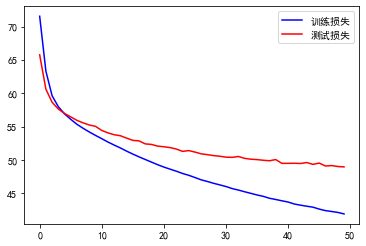

In [41]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False    # 步骤二（解决坐标轴负数的负号显示问题）
# 预测(回归)问题，一般看loss的变化；
# 分类问题，一般看acc的变化。
plt.plot( history.epoch, history.history.get('loss'), c = 'b', label = '训练损失' )
plt.plot( history.epoch, history.history.get('val_loss'), c = 'r', label = '测试损失' )
# plt.ylim( ymin=0.8 )
plt.legend()

为什么用普通的全连接层，效果这么差？

原因：在layers.Flatten()数据展平处，把原先前后数据之间“有规律联系”给**展平消除**了！

即：普通的全连接层根本感受不到那种前后数据间互相影响这点。这是全连接层网络的局限：**它只能做特征的汇聚！做不了高级特征的提取**。所以对于在时间轴上前后相互影响的数据，不管怎么调整全连接层，它都不会感受到这点。

# 五、模型搭建：简单单层LSTM

In [42]:
train_x.shape

(34924, 120, 11)

说明：LSTM层的输入数据就是3维的：(batch, 时间轴上考虑的时间(样本数)跨度, 每个样本里的特征数)

所以：数据之间输入即可。

形式：和前面的文本问题稍有不同，这里要设定input_shape参数，即(120,11) —— 前面的batch不用管，即“每个单位/组”的数据尺寸。

In [45]:
model = keras.Sequential()

先看看LSTM网络的工作机制是什么样的：

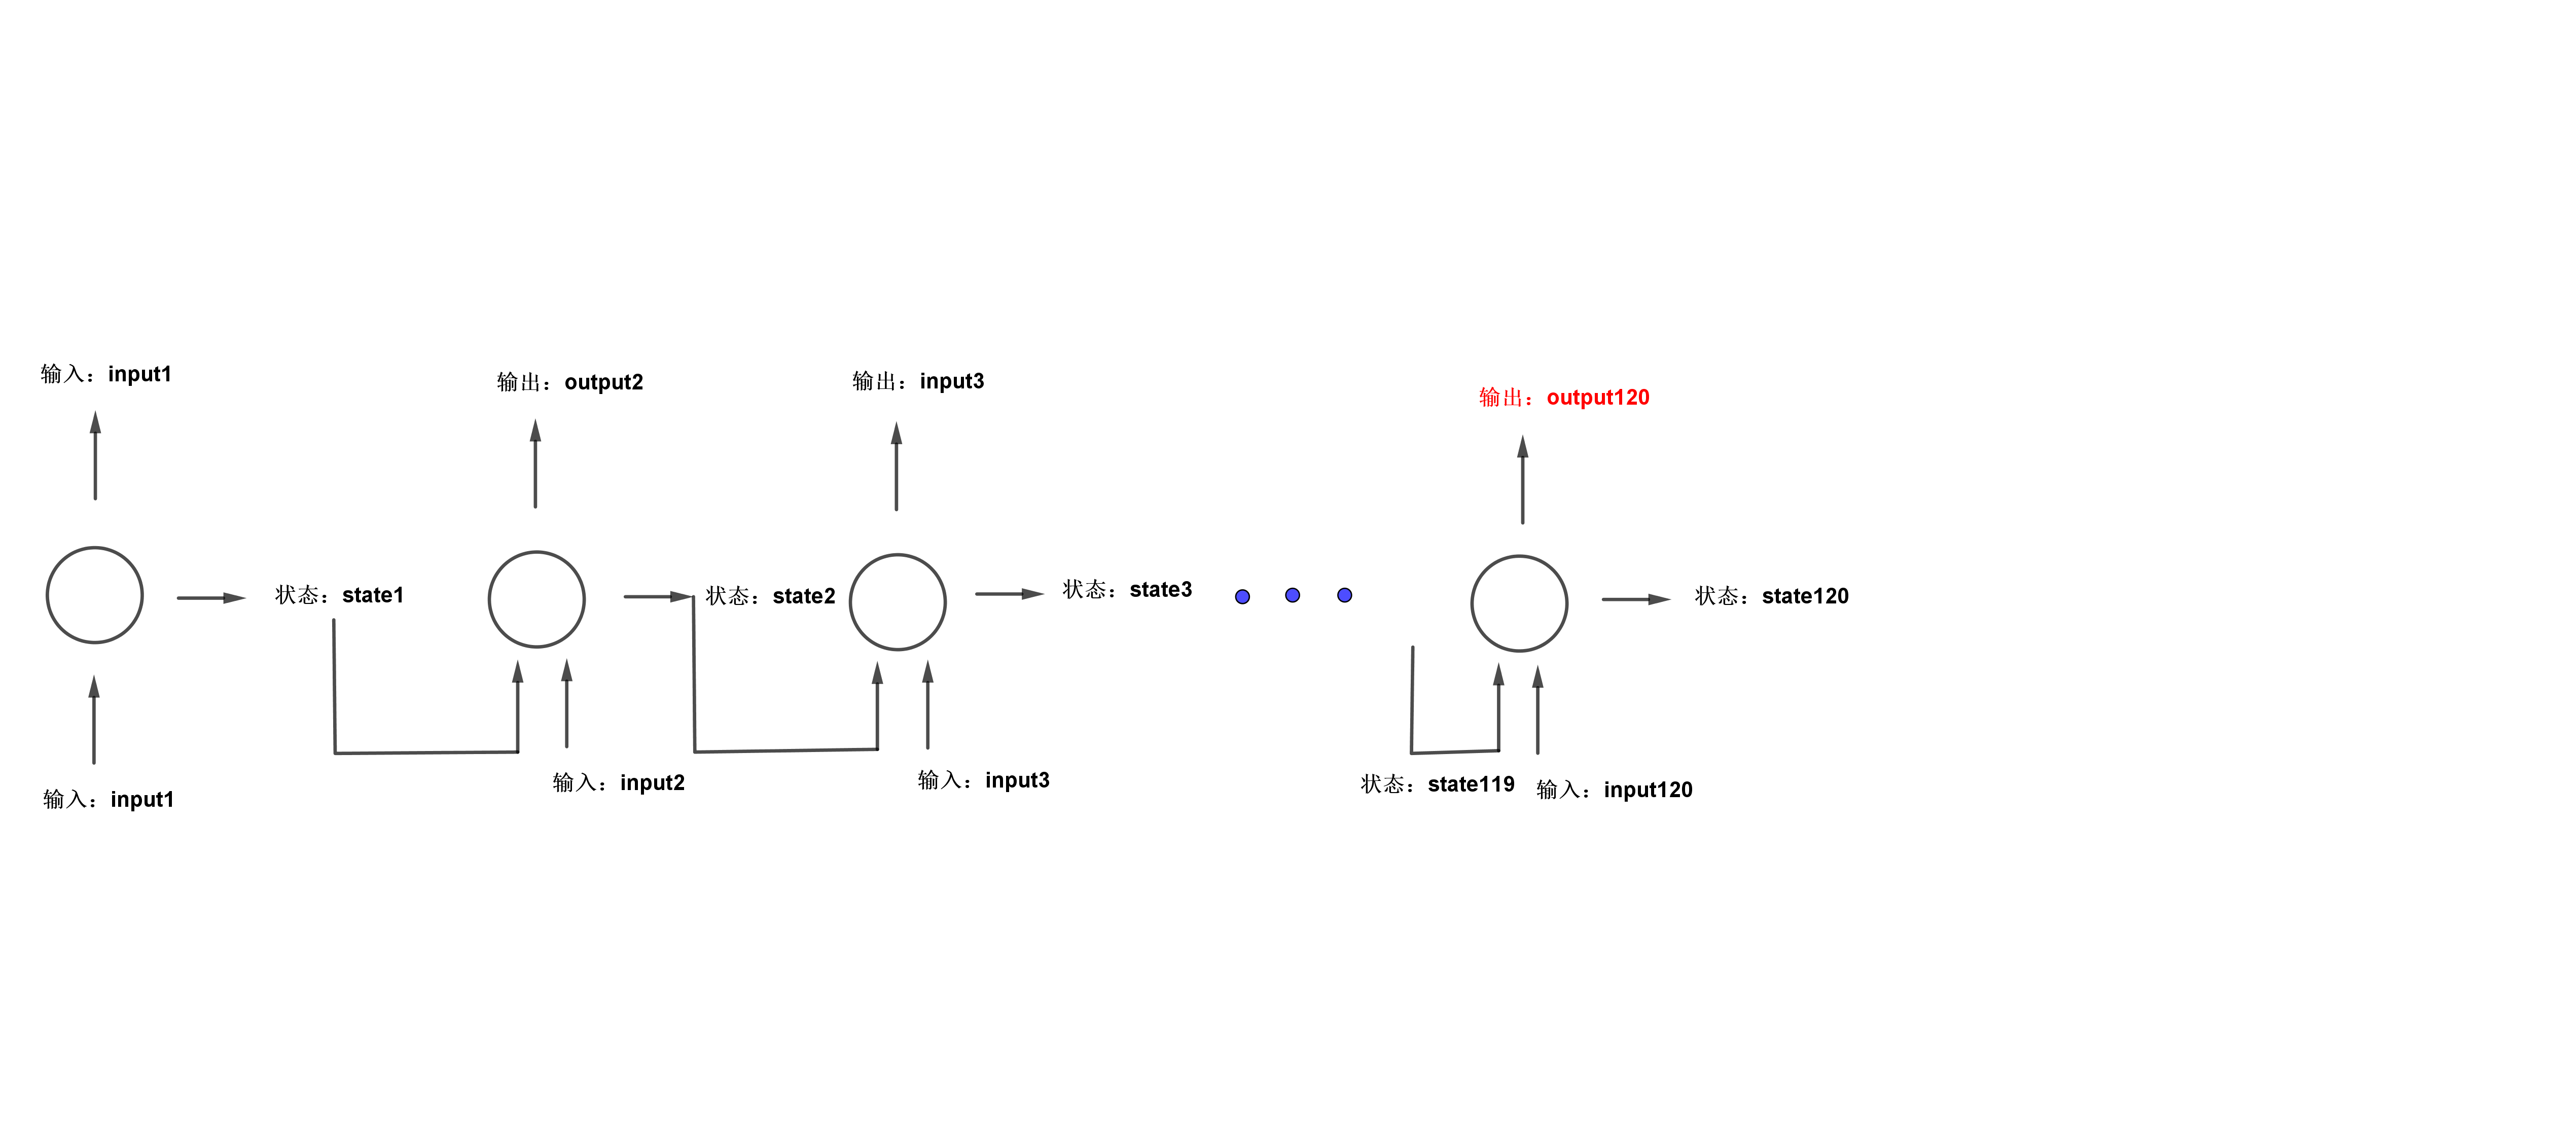

对于(120,11)的一组数据：
- “第1个数据”进入神经元1，获得“1个输出 + 1个记录数据1状态的变量”；
- “第2个数据 + 数据1状态变量”进入神经元2，获得“1个输出 + 1个记录数据2的状态”；
- ...
- “第120个数据 + 数据119状态变量”进入神经元120，获得“1个输出 + 1个记录数据120的状态”。此时我们只要当前的输出（就一个数）即可，因为获得这个数的过程，已经综合了前面所有数据的信息。

因此，LSTM网络只会输出一个数值结果，因此后面直接跟一个“只有1个神经元”的Dense层进行回归预测即可。

In [ ]:
model.add( layers.LSTM(32, input_shape=(120,11)) )  # 单层的写法：只要最后一个神经元的output
model.add( layers.Dense(1) )

In [ ]:
# “编译 + 训练”没有区别：
model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
# 理论上LSTM需要更多的特征提取机会，所以epochs要相对多一些！
history = model.fit( train_x, train_y, batch_size = 128, epochs = 150, validation_data=(test_x, test_y) )

# LSTM和CNN一样，都需要很大的计算量！

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False    # 步骤二（解决坐标轴负数的负号显示问题）
# 预测(回归)问题，一般看loss的变化；
# 分类问题，一般看acc的变化。
plt.plot( history.epoch, history.history.get('loss'), c = 'b', label = '训练损失' )
plt.plot( history.epoch, history.history.get('val_loss'), c = 'r', label = '测试损失' )
# plt.ylim( ymin=0.8 )
plt.legend()

现在网络的结果：理论上不会出现过拟合，预测效果稍有提高；但总体的效果提高的还是不令人满意！—— 还需要多网络搭建再改进。

# 六、模型搭建：优化LSTM —— 多层

In [87]:
model = keras.Sequential()

先看看多层LSTM的工作机制：

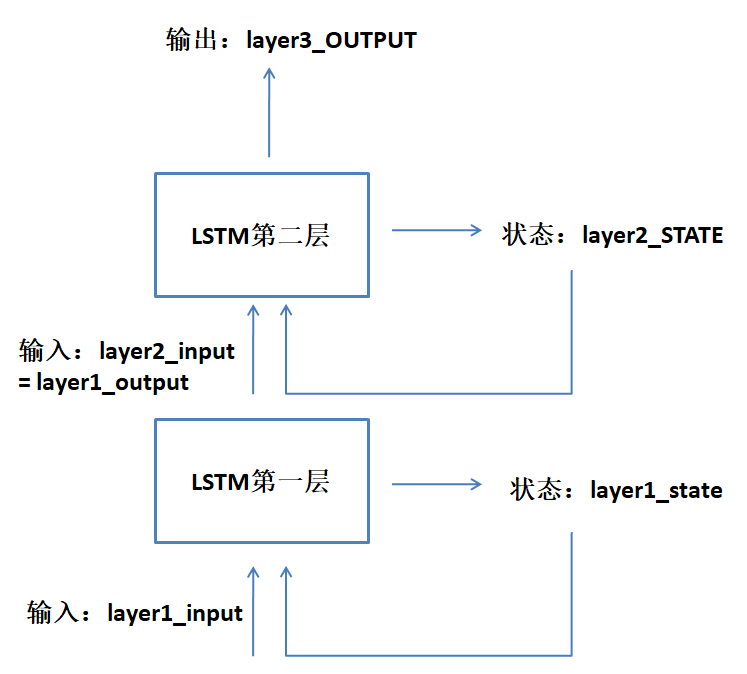

说明：还是对于(120,11)的一组数据，对于两层的LSTM工作机制如下：
- 第1个数据layers1_input1进入第1层LSTM，获得“1个输出layers1_output1 + 1个关于第1个数据的状态变量layers1_state1”；第1层LSTM所获得的输出，作为第2层LSTM的输入(layers2_input1 = layers1_output1)，第2层获得“1个输出layers2_OUTPUT1 + 1个关于第1个数据的状态变量layers2_STATE1”；
- 第2个数据“layers2_input2 + 第1个数据的状态变量layers_state1”进入第1层LSTM，获得“1个输出layers1_output2 + 1个关于第2个数据的状态变量layers1_state2”；“第1层LSTM所获得的输出layers1_input1 + 第2层中关于其第1个数据的状态变量layers2_STATE1”作为它的输入，获得“1个输出layers2_OUTPUT2 + 1个关于第2个数据的状态变量layers2_STATE2”
- ...
- 最后所要的还是一个值：最上面LSTM层的那最后一个数据的OUTPUT！

因此：多层LSTM堆叠时，要想完成“层1往层2传output的操作”，需要把变量return_sequences打开。但到了最上面一层时，就不用再把output传给谁了，因此无需打开这个变量。所有堆叠的LSTM层，其综合的、最后的输出还是一个值（最后一层的OUTPUT）！

In [88]:
model.add(layers.LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1))

In [89]:
# 编译：没有区别
model.compile( optimizer = keras.optimizers.Adam(), loss='mae')

### 补充一种小优化方法：随着训练epochs增加，学习率不断下降！ —— 回调函数

In [90]:
# keras.callbacks.ReduceLROnPlateau() “回调函数”经常使用！在model.fit()中加入
# monitor：监控的对象
# patience：如果连续3个epoch，monitor监控的对象都没有下降！就降低学习率。
# factor：让原先的学习率乘以0.5，就相当于降低学习率了 —— 这是一个超参数
# min_lr：学习率最小降到多少不再下降 —— 学习率不能一直减小，那训练就巨慢了！
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)

In [ ]:
# callbacks = [] —— 这个参数赋的是一个列表！
# 说明：同时可以用多个回调函数，对训练进行多个角度的监控与调控！
history = model.fit(train_x, train_y, batch_size = 128, epochs=200, validation_data=(test_x, test_y), 
                    callbacks=[learning_rate_reduction])

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False    # 步骤二（解决坐标轴负数的负号显示问题）
# 预测(回归)问题，一般看loss的变化；
# 分类问题，一般看acc的变化。
plt.plot( history.epoch, history.history.get('loss'), c = 'b', label = '训练损失' )
plt.plot( history.epoch, history.history.get('val_loss'), c = 'r', label = '测试损失' )
# plt.ylim( ymin=0.8 )
plt.legend()

现在网络的结果：精度又进一步的提升！！但是有一些“过拟合出现（loss不断下降，但val_loss开始不变）”—— 还可以更精进一步。

# 七、模型搭建：优化LSTM —— 循环dropout

在LSTM中的dropout，和直接在Dense中的dropout不太一样！—— 在LSTM中的dropout，处于循环中的神经元，每次dropout的单位必须是一样的！！

因为：如果每次都是随机的dropout循环中的单元，那么“序列信息”的传递就会发生多次的“随机中断”！这样会导致“误差传播与积累”。

在keras中，关于dropout设置的参数有两个，都在layers.LSTM()中：dropout与recurrent_dropout
- dropout控制：数据输入进来，有多少个神经元接受；
- recurrent_dropout控制：在这一LSTM层中不断循环时，多少“固定位置”神经元被杀死。

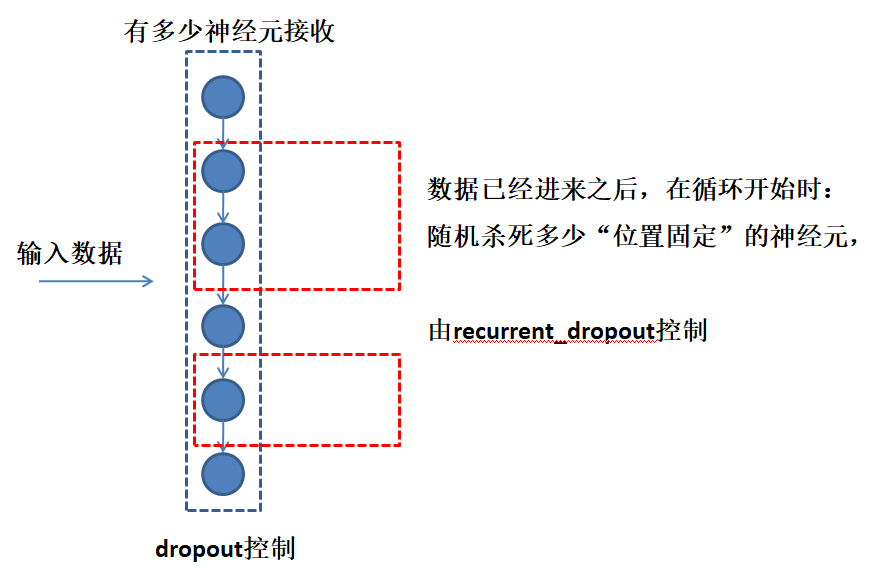

In [38]:
# 换一种更规范的写法，用函数定义的方式，来生成网络：
def train_model():
    model = keras.Sequential()
    # 在layers.LSTM中直接设置两个dropout参数：
    model.add( layers.LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True, dropout = 0.2, recurrent_dropout = 0.3) )
    model.add( layers.LSTM(32, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.3) )
    model.add( layers.LSTM(32, dropout = 0.2, recurrent_dropout = 0.3) )
    model.add( layers.Dense(1) )
    # 编译也在这个函数里完成：
    model.compile( optimizer = keras.optimizers.Adam(),
                   loss = 'mae'
    )
    return model

In [39]:
model = train_model()

In [ ]:
# 还是dropout的共同注意项：网络总容量肯定是减小了，因此训练轮次epochs要增多！
history = model.fit(train_x, train_y, batch_size = 128, epochs=250, validation_data=(test_x, test_y), 
                    callbacks=[learning_rate_reduction])

# 八、模型搭建：优化LSTM —— 双向LSTM

一种常见的RNN变体，一般用于“自然语言”会比普通的LSTM好一些。

思路来源：当我们判断一句话是“好话”还是“坏话”时，我们有时候“正向读完”没得出确切结论，那我们再“反向读完”。
这种，“**正、反一起读**”的策略还使得我们更能把握句子的“**整体**”！更能得出“**全局**”的结论。

思路类比：用CNN在图像识别时，它在进入最后的Dense层判断前，已经把整幅图仔细、完全、全局的看了一遍！
然后把“局部 + 全局”的特征提取出来。所以“双向RNN”与“CNN”都是对数据进行全局的把控。

网络设计：其实就是两个普通的LSTM网络，只不过一个正着处理数据，一个倒着处理数据，然后把二者所获得的信息综合分析。如图：

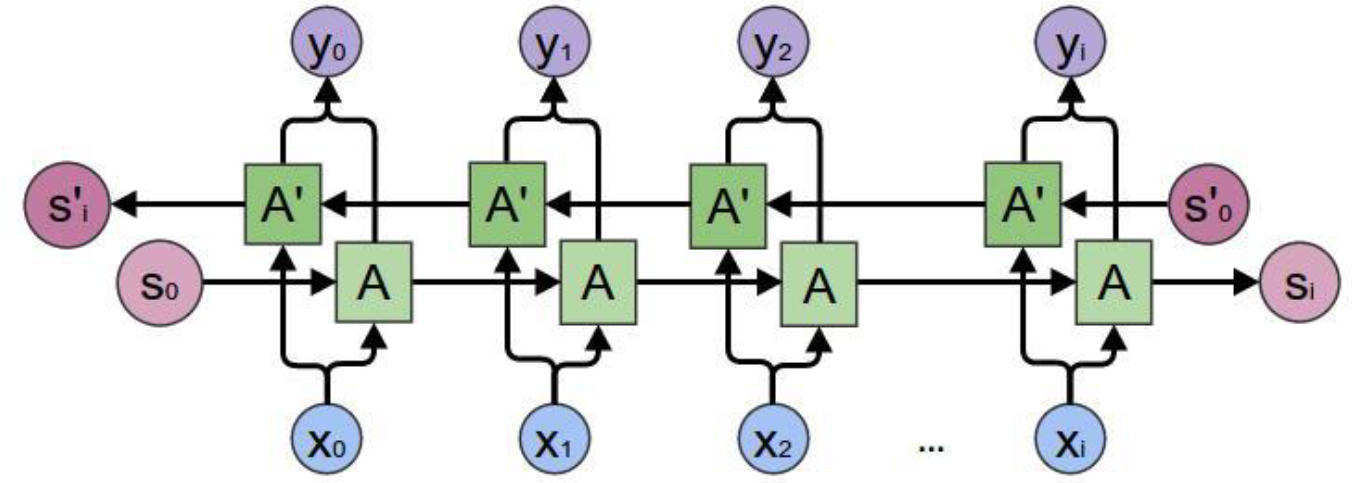

更加官方“网络设计”说明：双向RNN利用了RNN的顺序敏感性：它包含两个普通RNN，这两个RNN分别“各沿一个方向”对输入序列进行处理（时间正序和时间逆序），然后将它们的表示合并在一起。通过沿这两个方向处理序列，双RNN能够捕捉到可被单向RNN忽略的模式。

---
因为“序列数据”倒着处理数据没有实际意义（不可能用未来数据来反哺过去数据），因此双向RNN处理“自然语言”问题可能会有所提升。下面看文件40展示：用双向RNN处理“航空公司评论的情绪分类”。

---
在Keras中实现双向层，非常简单：
- layers.Bidirectional()：添加一个双向层；
- layers.Bidirectional( layers.LSTM() )：添加一个双向的LSTM层 —— 直接加它里面即可！